## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

This notebook will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of the project, the model will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

Based on a real-world setting, a series of models will be pieced together to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  The imperfect solution is just meant for some fun

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

train_path='Simpsons/train'

def load_dataset(path):
    data = load_files(path)
    pics = np.array(data['filenames'])
    characters = np_utils.to_categorical(np.array(data['target']), 48)
    return pics, characters

X,y=load_dataset(train_path)

ModuleNotFoundError: No module named 'sklearn'

In [35]:
import scipy
import cv2
pic_size = 64
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def showImage(imgPath):
    image = cv2.imread(imgPath)
    colour = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(colour)
    return imgplot

In [40]:
X=load_files('Simpsons/train')
X['filenames']
#X['target']

array(['Simpsons/train/martin_prince/pic_0024.jpg',
       'Simpsons/train/moe_szyslak/pic_0930.jpg',
       'Simpsons/train/moe_szyslak/pic_0051.jpg', ...,
       'Simpsons/train/krusty_the_clown/pic_0646.jpg',
       'Simpsons/train/lisa_simpson/pic_0077.jpg',
       'Simpsons/train/bart_simpson/pic_1048.jpg'], 
      dtype='<U52')

In [ ]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
path='/data/dog_images/train'
data= load_files(path)
data


In [22]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/Simpsons/train/')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


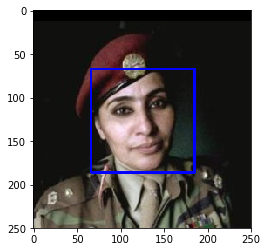

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (TASK) Assess the Human Face Detector

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ The algorithm identified the human faces 100% correctly and incorrectly classified 11 images of dogs as humans. This is a good sign for our algorithm as it's purpose is to classify people, although it is not great that we are mistaking some dogs for people.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
humans=0
dogs=0

for i in human_files_short:
    if face_detector(i)==True:
        humans += 1
    
for i in dog_files_short:
    if face_detector(i)==True:
        dogs += 1

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
print(f" Humans identified as human: {humans}%")
print(f" Dogs identified as human: {dogs}%")


 Humans identified as human: 100%
 Dogs identified as human: 11%


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ A facial recognition algorithm that only works for images with a clear view of the face is not very practical. Ideally our modelwould be dynamic enough to classify human faces regardless of the location or profile of face in the image. Shapes such as 2 circles for eyes, a roughly triangular nose, a round head etc are very well defined features common to all human faces (except for someone unlucky)  that we would a expect a good model to be able to identify. Our model should be trained on a variety of images & the user should be able to supply an image of reasonable quality & expect it to be appropriate for classification. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (TASK) Assess the Dog Detector

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human=0
dog=0

for i in human_files_short:
    if dog_detector(i) == True:
        human+=1
        
for i in dog_files_short:
    if dog_detector(i) == True:
        dog+=1
        
        
print(f" Humans identified as dogs: {human}%")
print(f" Dogs identified as dogs: {dog}%")      


 Humans identified as dogs: 0%
 Dogs identified as dogs: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.20it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ In finding the final CNN i initially tried a number of different models. The ResNet format of having stacks of small convolutional layers in a row, separated by a max pooling layer was interesting, and I tried to take a similar approach. Unfortunatley my attempts did not prove very accuarte and was quite time consuming to train. I scaled down my efforts and instead focused on having 2 stacks of 2 convolutional layers. I believe this format works well with the data. The initial two layers has a smaller filter size, ideally I would like thisto pick up the major identifiers of a dog in the image - long ears/snout/shape of face/4 legs etc. I was hoping the second layer would be useful in then identifying difference between the breeds of dog.

I stacked 2 convolutional layers with a max pooling layer following them to reduce teh dimensionality. I maintained a relu actiavtion throughout as I felt this was the best practice. having tried various combinations of stride & padding, I was satisfied to also maintain the default on these.After my 2 convolutional stacks I followed up with a final GlobalAveragePooling to completely reduce the structure to a vector format so that I could attach a fully connected layer. With this layer I specified a Dropout parameter of 0.3, which meant that there was a 30% chance a node could be left out of each epoch. This was to avoid overfitting the model.

My final accuracy output was 2.631%

I felt somewhat limited by the computation power available (in regards time to train) and would be interested in running a large custom model similar to resNet, with many small convolutional layers stacked together.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=8,kernel_size=2,activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(filters=8,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=16,kernel_size=2,activation='relu'))
model.add(Conv2D(filters=16,kernel_size=2,activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 8)       104       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 8)       264       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      528       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 16)      1040      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (Task) Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

We could [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs=5


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 28s 4ms/step - loss: 4.8823 - acc: 0.0099 - val_loss: 4.8687 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 27s 4ms/step - loss: 4.8707 - acc: 0.0108 - val_loss: 4.8667 - val_acc: 0.0108
Epoch 3/5
6680/6680 [==============================] - 27s 4ms/step - loss: 4.8638 - acc: 0.0115 - val_loss: 4.8535 - val_acc: 0.0120
Epoch 4/5
6680/6680 [==============================] - 27s 4ms/step - loss: 4.8347 - acc: 0.0141 - val_loss: 4.8168 - val_acc: 0.0108
Epoch 5/5
6680/6680 [==============================] - 27s 4ms/step - loss: 4.7826 - acc: 0.0172 - val_loss: 4.7730 - val_acc: 0.0240


### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### (Task) Test the Model

Try out our model on the test dataset of dog images.  Ensure that the test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.5120%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, show how a CNN can be trained using transfer learning. In the following step, you take the chance to use transfer learning to train our own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 326us/step - loss: 13.2468 - acc: 0.0885 - val_loss: 11.9097 - val_acc: 0.1569
Epoch 2/20
6680/6680 [==============================] - 2s 272us/step - loss: 10.9650 - acc: 0.2302 - val_loss: 10.6959 - val_acc: 0.2599
Epoch 3/20
6680/6680 [==============================] - 2s 276us/step - loss: 10.2852 - acc: 0.3025 - val_loss: 10.4769 - val_acc: 0.2623
Epoch 4/20
6680/6680 [==============================] - 2s 276us/step - loss: 9.9490 - acc: 0.3392 - val_loss: 10.2020 - val_acc: 0.3042
Epoch 5/20
6680/6680 [==============================] - 2s 259us/step - loss: 9.7767 - acc: 0.3600 - val_loss: 10.0879 - val_acc: 0.3126
Epoch 6/20
6680/6680 [==============================] - 2s 260us/step - loss: 9.6992 - acc: 0.3708 - val_loss: 10.0332 - val_acc: 0.3210
Epoch 7/20
6680/6680 [==============================] - 2s 261us/step - loss: 9.6056 - acc: 0.3858 - val_loss: 10.0802 - val_acc

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.4737%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.  We'd ideally attain about 60% accuracy on the test set with our CNN.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I use the bottleneck features from a different pre-trained model.  To make things easier, I've downloaded the pre-computed the features for all of the networks that are currently available in Keras, made available by Udacity.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (Task) Obtain Bottleneck Features

In the code block below, I extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

### (Task) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of the model by executing the line:
    
        <your model's name>.summary()
   
Outline the steps you took to get to the final CNN architecture and the reasoning at each step.  Describe how the architecture is suitable for the current problem.

__Answer:__ The Steps I took to choose the final model were to run a number of variations of paramaters again and to choose the optimal combination. It appears that implementing transfer learning using the inceptionv3 CNN as a precursor dramatically boosts the image classification performance. My model attains 77% classification accuracy. 

The logic to the structure I decided on was to connect a fully connected layer to the output of the inception3 CNN. Using the Global Average Pooling to take the maximum of each output and feeding it said fully connected layer. i chose 256 for the number of nodes in an attempt to reduce the dimensionality before feeding it to the final classification layer with 133 nodes. 



In [26]:
### TODO: Define your architecture.
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))

inception_model.add(Dense(256,activation="relu"))
inception_model.add(Dropout(0.2))

inception_model.add(Dense(133, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (Task) Compile the Model

In [27]:
### TODO: Compile the model.
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (Task) Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

I could [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 437us/step - loss: 1.6155 - acc: 0.6160 - val_loss: 0.7489 - val_acc: 0.7844
Epoch 2/20
6680/6680 [==============================] - 3s 395us/step - loss: 0.7199 - acc: 0.7933 - val_loss: 0.7345 - val_acc: 0.7976
Epoch 3/20
6680/6680 [==============================] - 3s 396us/step - loss: 0.5694 - acc: 0.8289 - val_loss: 0.6402 - val_acc: 0.8407
Epoch 4/20
6680/6680 [==============================] - 3s 388us/step - loss: 0.4753 - acc: 0.8546 - val_loss: 0.7202 - val_acc: 0.8287
Epoch 5/20
6680/6680 [==============================] - 3s 392us/step - loss: 0.4053 - acc: 0.8799 - val_loss: 0.7964 - val_acc: 0.8287
Epoch 6/20
6680/6680 [==============================] - 3s 387us/step - loss: 0.3697 - acc: 0.8853 - val_loss: 0.8552 - val_acc: 0.8120
Epoch 7/20
6680/6680 [==============================] - 3s 391us/step - loss: 0.3187 - acc: 0.9006 - val_loss: 0.8778 - val_acc: 0.8299
E

### (Task) Load the Model with the Best Validation Loss

In [29]:
### TODO: Load the model weights with the best validation loss.
inception_model.load_weights('saved_models/weights.best.inception.hdf5')

### (Task) Test the Model

Try out our model on the test dataset of dog images. Ensure that our test accuracy is greater than 60%.

In [30]:
### TODO: Calculate classification accuracy on the test dataset.
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.3923%


### (Task) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to the chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception` provided by Udacity.

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


---
<a id='step6'></a>
## Step 6: Write the classification Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

I could write my own functions for detecting humans and dogs in images, but it's easiest to use the `face_detector` and `dog_detector` functions developed above.  It's __required__ to use the CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below

![Sample Human Output](images/sample_human_output.png)


### (Task) Write your Algorithm

In [32]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from IPython.core.display import Image, display

def showImage(imgPath):
    imgage = cv2.imread(imgPath)
    colour = cv2.cvtColor(imgage, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(colour)
    return imgplot
        

def classifyThisBeing(imgPath):
    showImage(imgPath)
    if dog_detector(imgPath):
        print("This is a good dog")
        #display(Image(image_path,width=200,height=200))
        inception_predict_breed(imgPath)
        pred=inception_predict_breed(imgPath)
        return print("This dog looks like a {}".format(pred))
    elif face_detector(imgPath):
        print("This is not a good dog")
        #display(Image(image_path,width=200,height=200))
        pred=inception_predict_breed(imgPath)
        return print("This person looks like a {}".format(pred))
    else:
        return ("The picture must be man or his best friend")
    


---
<a id='step7'></a>
## Step 7: Test the Algorithm

In this section, we take our new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (Task) Test Your Algorithm on Sample Images!

I've provided the algorithm with a mix of dog and human faces to try and classify.

Is the output better than expected or worse?  Provide at least three possible points of improvement for the algorithm.

__Answer:__  The output is pretty much what I expected. It is able to recognise people quite well, and catches most of the human images passed in. It does relatively well for identifying dogs, and even gets 2 identifications right - the bulldog & labrador. It can classify correctly for these "easy" cases. It fails to pick up the picture of the direwolf & clifford as dogs. Possible points of improvement for the algo could be 

- utilise data augmentation when training the model
- Simply spending more time fine tuning the models parameters. Trying the find the optimal format of the NN could yield better classification results. Also running over more epochs (while avoiding overfitting). 
- Use a different more advanced algorithm with complicated convolutional layers such as VGG16/VGG19

In [33]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

#dog_files = train_files[:50-100]

#for file in np.hstack((human_files[:3], dog_files[:3])):
    #classifyThisBeing(file)
#showImage('testImages/cat.jpg')
    
#classifyThisBeing('testImages/cat.jpg')
#classifyThisBeing('testImages/amyPoehler.jpg')
#classifyThisBeing('testImages/bulldog.jpeg')
#classifyThisBeing('testImages/dog3.jpg')
#classifyThisBeing('testImages/Clifford.jpg')
#classifyThisBeing('testImages/easterisland.jpg')
#classifyThisBeing('testImages/LucyLiu.jpg')
#classifyThisBeing('testImages/obama.jpg')
#classifyThisBeing('testImages/skeletor.jpg')

'The picture must be man or his best friend'

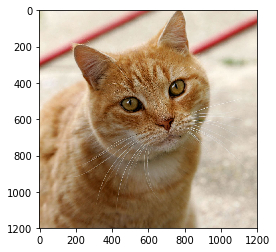

In [34]:
classifyThisBeing('testImages/cat.jpg')

This is not a good dog
87916544/87910968 [==============================] - 1s 0us/step
This person looks like a in/049.Chinese_crested


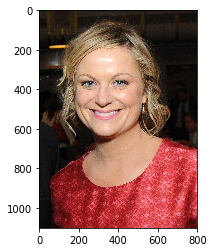

In [35]:
classifyThisBeing('testImages/amyPoehler.jpg')

This is a good dog
This dog looks like a in/040.Bulldog


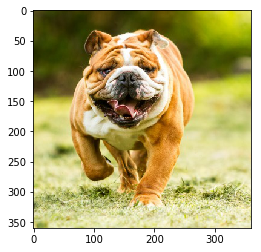

In [36]:
classifyThisBeing('testImages/bulldog.jpeg')

This is a good dog
This dog looks like a in/067.Finnish_spitz


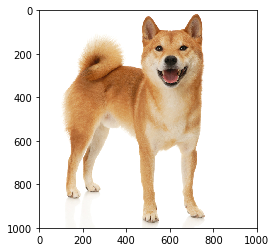

In [37]:
classifyThisBeing('testImages/dog3.jpg')

'The picture must be man or his best friend'

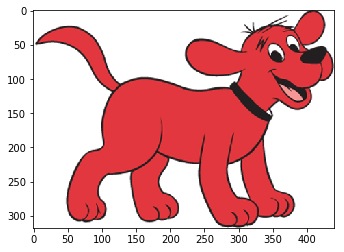

In [38]:
classifyThisBeing('testImages/Clifford.jpg')

'The picture must be man or his best friend'

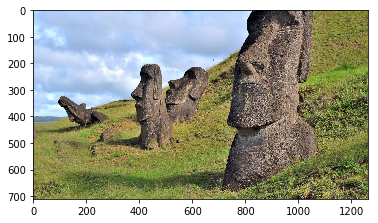

In [39]:
classifyThisBeing('testImages/easterisland.jpg')

This is not a good dog
This person looks like a in/010.Anatolian_shepherd_dog


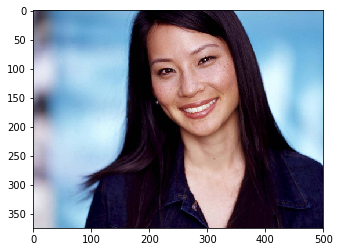

In [40]:
classifyThisBeing('testImages/LucyLiu.jpg')

This is not a good dog
This person looks like a in/056.Dachshund


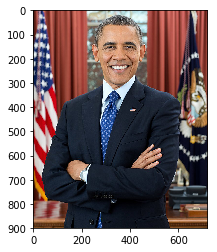

In [41]:
classifyThisBeing('testImages/obama.jpg')

This is not a good dog
This person looks like a in/049.Chinese_crested


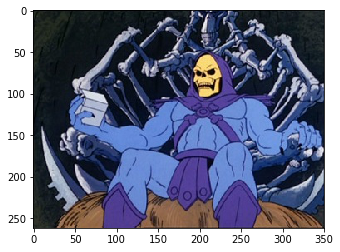

In [42]:
classifyThisBeing('testImages/skeletor.jpg')

This is a good dog
This dog looks like a in/096.Labrador_retriever


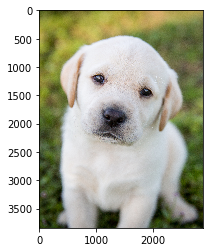

In [43]:
classifyThisBeing('testImages/dog4.jpg')

This is a good dog
This dog looks like a in/062.English_setter


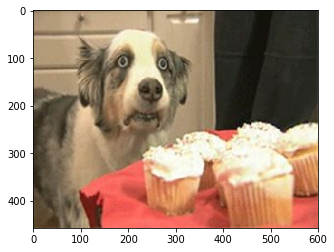

In [44]:
classifyThisBeing('testImages/dog5.jpg')

'The picture must be man or his best friend'

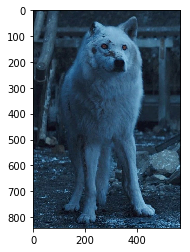

In [47]:
classifyThisBeing('testImages/wolf.jpg')

This is not a good dog
This person looks like a in/005.Alaskan_malamute


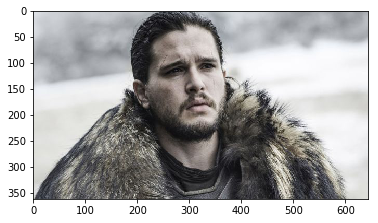

In [48]:
classifyThisBeing('testImages/jon.jpg')